In [ ]:
%load_ext autoreload
%autoreload 2
# General imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.lines import Line2D
import sys
import os
import pandas as pd
import yaml
from copy import deepcopy
from cProfile import Profile
import networkx as nx
# picture path
PICS = '../pics/'
# Module imports
sys.path.append("../")
from contagion import Contagion, config
from contagion.config import _baseconfig
import seaborn as sns
import datetime
import pyabc

In [ ]:
def mod_df(df, colname):
    df_de = df.loc[df["ISO 3166-1 Alpha 3-Codes"]=="DEU", ["Date", "Value"]]
    df_de["Date"] = pd.to_datetime(df_de["Date"], yearfirst=True)
    df_de = df_de.astype({"Value": "int"})
    df_de[colname] = df_de["Value"] / 80E6 * 1E6
    df_de.set_index("Date", inplace=True)
    df_de.drop("Value", axis=1, inplace=True)
    return df_de
    

In [ ]:
#df_tot = mod_df(pd.read_csv("time_series_covid19_confirmed_global_narrow.csv"), "tot. infected")
#df_deaths = mod_df(pd.read_csv("time_series_covid19_deaths_global_narrow.csv"), "deaths")
#df_rec = mod_df(pd.read_csv("time_series_covid19_recovered_global_narrow.csv"), "recovered")
#df_de = pd.concat([df_tot, df_deaths, df_rec], axis=1).sort_index()
#df_de.to_csv("data_germany.csv")

In [4]:
full = True
data = pd.read_csv("data_germany.csv")
data["Date"] = pd.to_datetime(data['Date'])
if full:
    data = data.set_index("Date").loc[pd.to_datetime('2020-02-24'):]
else:
    data = data.set_index("Date").loc[pd.to_datetime('2020-02-24'):pd.to_datetime('2020-03-20')]
fields = ["is_recovered", "is_infected_total", "is_dead"]
#data = {field: np.asarray(contagion.statistics[field]) for field in fields}
data = {"is_recovered": data["recovered"], "is_infected_total": data["tot. infected"], "is_dead": data["deaths"]}

In [5]:
my_config = yaml.safe_load(open("fit_germany_conf.yaml"))

In [6]:

def model(parameters):
    this_config = dict(_baseconfig)
    this_config.update(my_config)
    this_config['population']['population size'] = 100000
    this_config['population']['social circle pdf']["mean"] = parameters["soc circ mean"]

    this_config['population']['social circle interactions pdf']["mean"] = parameters["soc circ mean"]        
    this_config['infection']["latency duration pdf"]['mean'] =  parameters["latency mean"]        
    this_config['infection']["infectious duration pdf"]['mean'] =  parameters["infectious dur mean"]        
    this_config['infection']["recovery time pdf"]['mean'] =  parameters["recovery dur mean"]        
    this_config['infection']["incubation duration pdf"]['mean'] =  parameters["incub dur mean"]        
    this_config['infection']["infection probability pdf"]['max_val'] =  parameters["inf prob max"]
    this_config['infection']["incubation duration pdf"]['sd'] =  parameters["incub dur sd"] 

    this_config["infection"]["mortality prob pdf"]["mean"] = parameters["mort mean"]
    this_config["infection"]["mortality prob pdf"]["sd"] = parameters["mort sd"]

    this_config["infection"]["will have symptoms prob pdf"]["mean"] = parameters["symp prob mean"]
    this_config["infection"]["will have symptoms prob pdf"]["sd"] = parameters["symp prob sd"]

    if full:
        this_config["scenario"]["class"] = "SocialDistancing"

        start_scaling = int(parameters["t_start_dist"])
        end_scaling = int(parameters["t_end_dist"])
        final_inf_per_day = parameters["int_per_day_dist"]

        slope = (parameters["soc circ mean"] - final_inf_per_day) / (start_scaling-end_scaling)
        offset =  parameters["soc circ mean"] - slope * start_scaling
        t_steps = np.arange(start_scaling)
        if len(t_steps)==0:
            raise RuntimeError("Help ",start_scaling, end_scaling)
        this_config["scenario"]["t_steps"] = list(t_steps)
        this_config["scenario"]["contact_rate_scalings"] = list(slope*t_steps + offset)

    else:
        this_config["scenario"]["class"] = "StandardScenario"
    this_config["measures"]["tracked fraction"] = 1.0

    this_config["population"]["re-use population"] = False
    contagion = Contagion(userconfig=this_config)
    contagion.sim()

    stats = pd.DataFrame(contagion.statistics)
    stats["is_infected_total"] = stats["is_recovered"] + stats["is_recovering"] + stats["is_infected"]

    #stats = stats / this_config['population']['population size'] * 80E6
    stats["is_infected_total"] *= parameters["id_fraction"]
    stats["is_recovered"] *= parameters["id_fraction"]

    zero_rows = pd.DataFrame({col: np.zeros(int(parameters["timeshift"])) for col in stats.columns})
    stats = pd.concat([zero_rows, stats]).reset_index()
    return stats.iloc[:len(data["is_recovered"])]
    

In [21]:
my_config["population"]["population size"] = 1000000
my_config["population"]["population class"] = "HomogeneousPopulation"
#my_config["population"]["population class"] = "NetworkXPopulation"
my_config["population"]["population storage"] = "1E6_homogeneous.pickle"
my_config["population"]["re-use population"] = False
my_config["general"]["random state seed"] = 3

int_rate = 8
#int_rate = 7
#int_rate = 13
my_config["population"]["social circle interactions pdf"]["mean"] = int_rate
my_config["population"]["social circle interactions pdf"]["sd"] = 0.1
my_config["population"]["social circle pdf"]["mean"] = int_rate
my_config["population"]["social circle pdf"]["sd"] = 0.1

my_config["population"]["nx"]['inter freq pdf']["mean"] = int_rate
my_config["population"]["nx"]['intra freq pdf']["mean"] = int_rate

my_config["infection"]["infected"] = 5
my_config["infection"]["hospitalization probability pdf"] = {
    "class": "Beta",
    "mean": 0.26,
    "sd": 0.01}
my_config["infection"]["hospitalization duration pdf"] = {"class": "Gamma",
    "mean": 12.,
    "sd": 3}
my_config["infection"]["time until hospitalization pdf"] = {"class": "Gamma",
    "mean": 7,
    "sd": 2.}
my_config["infection"]["time incubation death pdf"] = {
    "class": "Gamma",
    "mean": 9,
    "sd": 2.}
my_config["infection"]["mortality prob pdf"] = {
    "class": "Beta",
    "mean": 0.155,
    "sd": 0.01}
my_config["infection"]['incubation duration pdf']["mean"] = 6
my_config["infection"]['incubation duration pdf']["sd"] = 12

t_start_ld = 19

my_config["scenario"]["class"] = "SocialDistancing"
my_config["scenario"]["t_steps"] = [0, t_start_ld, t_start_ld+4, t_start_ld+10, t_start_ld+20, t_start_ld+20 + 26, t_start_ld+20 + 26+28]
my_config["scenario"]["contact_rate_scalings"] = [6./int_rate, 5./int_rate,  2.5/int_rate, 1/int_rate, 0.6/int_rate, 6/int_rate, 1]
my_config["measures"]["tracked fraction"] = 1.0
my_config["infection"]["will have symptoms prob pdf"]["mean"] = 0.3
my_config["infection"]["will have symptoms prob pdf"]["sd"] = 0.01

In [22]:
#yaml.dump(my_config, open("fit_germany_conf.yaml", "w"))

In [7]:
db_path = "sqlite:///" + os.path.join(os.environ["HOME"], "abc_ger.db")
h_loaded = pyabc.History(db_path)

'    \nplt.xlabel("Time [days]")\nplt.ylabel("Counts")\nplt.legend()\nplt.xlim(0, 150)\n'

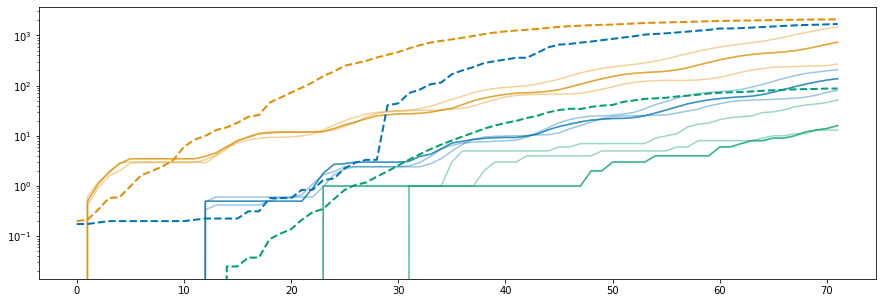

In [8]:
plt.figure(figsize=(15, 5))
colors = sns.color_palette("colorblind", 3)
df, w = h_loaded.get_distribution(m=0)
for i in range(5):
    pars = df.sample(1, weights=w).to_dict(orient="list")
    pars = {key: val[0] for key, val in pars.items()}
   
    #pars["recovery dur mean"] = 0.01
    sim_data = model(pars)
    for field, col in zip(fields, colors):
        plt.plot(sim_data[field], color=col, alpha=0.4)

for field, col in zip(fields, colors):
    plt.plot(data[field].values, color=col, ls="--", label=field, lw=2)
plt.semilogy()
"""
mean_sim, _ = model(par_modes)
for field, col in zip(fields, colors):
    plt.plot(mean_sim[field], color=col, ls="-", label=field, lw=3)
""" 

"""    
plt.xlabel("Time [days]")
plt.ylabel("Counts")
plt.legend()
plt.xlim(0, 150)
"""
#plt.semilogy()

In [9]:
h_loaded.id

22

[]

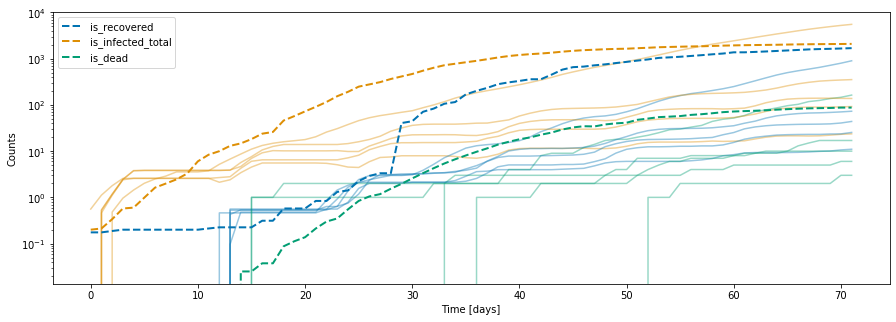

In [10]:
sorted_pop = h_loaded.get_population_extended().sort_values("distance")
bfs = [{par_name[4:]: sorted_pop.iloc[i][par_name].item() for par_name in sorted_pop.iloc[i].index if "par" in par_name} for i in range(10)]
plt.figure(figsize=(15, 5))
colors = sns.color_palette("colorblind", 3)
min_dists = h_loaded.get_weighted_distances().sort_values("distance").index[:10]
df, w = h_loaded.get_distribution(m=0)
for i in range(5):  
    pars = bfs[i]
    sim_data = model(pars)
    #conf = deepcopy(conf)
    #yaml.dump(conf, open("par_set_{}.yaml".format(i), "w"))
    for field, col in zip(fields, colors):
        plt.plot(sim_data[field], color=col, alpha=0.4)
for field, col in zip(fields, colors):
    plt.plot(data[field].values, color=col, ls="--", label=field, lw=2)
    
"""
mean_sim, _ = model(par_modes)
for field, col in zip(fields, colors):
    plt.plot(mean_sim[field], color=col, ls="-", label=field, lw=3)
""" 

    
plt.xlabel("Time [days]")
plt.ylabel("Counts")
plt.legend()
#plt.xlim(0, 150)
plt.semilogy()

[]

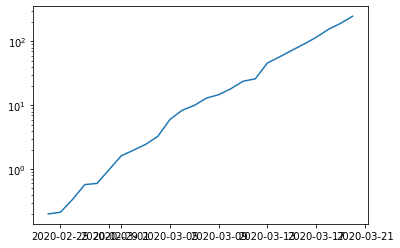

In [45]:
plt.plot(data["is_infected_total"].loc[pd.to_datetime('2020-02-24'):, ])
plt.semilogy()

In [9]:
contagion = Contagion(my_config)
prof = Profile()
contagion.sim()
stats = pd.DataFrame(contagion.statistics)

In [10]:
pd.to_datetime('2020-05-05')- pd.to_datetime('2020-02-20') - datetime.timedelta(22)

Timedelta('53 days 00:00:00')

In [11]:
pd.to_datetime('2020-03-20')- pd.to_datetime('2020-03-01') #- datetime.timedelta(22)

Timedelta('19 days 00:00:00')

,tot. infected,deaths,recovered
0,0.0000,0.0000,0.00
1,0.0000,0.0000,0.00
2,0.0000,0.0000,0.00
3,0.0000,0.0000,0.00
4,0.0000,0.0000,0.00
...,...,...,...
2020-05-01 00:00:00,2050.9625,84.2000,1586.25
2020-05-02 00:00:00,2062.0875,85.1500,1612.50
2020-05-03 00:00:00,2070.8000,85.8250,1632.50
2020-05-04 00:00:00,2076.9000,87.4125,1658.75


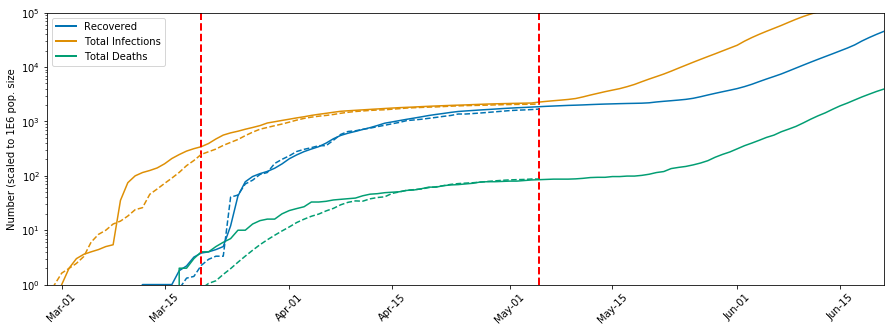

In [12]:
# LOOK AT PER DAY. CUMULATIVE SUMS UP ERRORS
plt.figure(figsize=(15, 5))
colors = sns.color_palette("colorblind", 3)
t_start = '2020-03-01'
id_rate = 0.2
taxis = pd.date_range(t_start, '2020-06-21', freq="d")



plt.plot(taxis, stats["is_recovered"][:len(taxis)]*id_rate, color=colors[0])
plt.plot(taxis, stats["is_infected"][:len(taxis)]*id_rate + stats["is_recovered"][:len(taxis)]*id_rate, color=colors[1])
plt.plot(taxis, stats["is_dead"][:len(taxis)], color=colors[2])

plt.axvline(pd.to_datetime(t_start)+datetime.timedelta(days=t_start_ld), color='r', linestyle='--', lw=2)
plt.axvline(pd.to_datetime(t_start)+datetime.timedelta(days=46+t_start_ld), color='r', linestyle='--', lw=2)
    



plt.plot(df_de.index, df_de["recovered"], color=colors[0], ls="--")
plt.plot(df_de.index, df_de["tot. infected"], color=colors[1], ls="--")
plt.plot(df_de.index, df_de["deaths"], color=colors[2], ls="--")
plt.xticks(rotation=45)

plt.semilogy()
date_form = DateFormatter("%b-%d")
plt.gca().xaxis.set_major_formatter(date_form)
plt.ylim(1, 1E5)
plt.xlim(datetime.date(2020, 2, 28), datetime.date(2020, 6, 21))

proxies = [
    Line2D([], [], lw=2, color=colors[0]),
    Line2D([], [], lw=2, color=colors[1]),
    Line2D([], [], lw=2, color=colors[2])]
labels = ["Recovered", "Total Infections", "Total Deaths"]
plt.legend(proxies, labels)
plt.ylabel("Number (scaled to 1E6 pop. size")
plt.savefig(os.path.join(PICS, "comp_ger_homogeneous.png"), dpi=150)


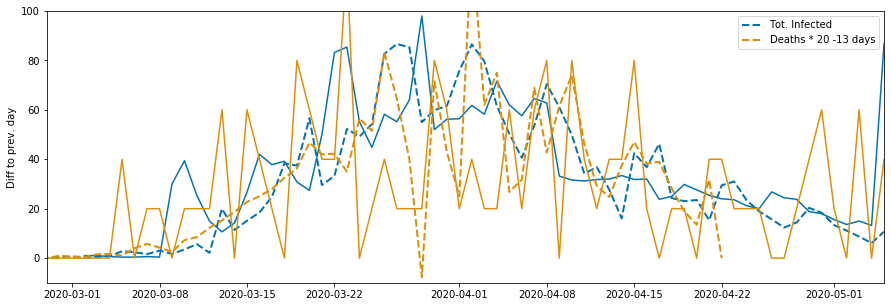

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(taxis[1:], np.diff(stats["is_infected"][:len(taxis)]+stats["is_recovered"][:len(taxis)])*id_rate, color=colors[0])

#plt.axvline(pd.to_datetime('2020-03-21'), color='r', linestyle='--', lw=2)

plt.plot(df_de.index[1:], np.diff(df_de["tot. infected"]), color=colors[0], ls="--", lw=2, label="Tot. Infected")
plt.plot(df_de.index[1:]-datetime.timedelta(13), np.diff(df_de["deaths"])*20, color=colors[1], ls="--", lw=2, label="Deaths * 20 -13 days")
plt.plot(taxis[1:]-datetime.timedelta(12), np.diff(stats["is_dead"][:len(taxis)])*20, color=colors[1], ls="-")
plt.ylim(-10, 100)
plt.xlim(datetime.date(2020, 2, 28), datetime.date(2020, 5, 5))
plt.legend()
plt.ylabel("Diff to prev. day")
plt.savefig(os.path.join(PICS + "germany_diff.png"), dpi=150)

In [263]:
stats["tot. infected"] = stats["is_infected"]+stats["is_recovered"]

In [1]:
shifts = np.arange(-15, 0)
for shift in shifts:
    plt.plot(shift, stats["tot. infected"].corr(stats["is_dead"].shift(shift)), "or")
    plt.plot(shift, df_de["tot. infected"].corr(df_de["deaths"].shift(shift)), "ok")
plt.ylabel("Cross correlation")
plt.xlabel("Lag")
plt.tight_layout()
plt.savefig(os.path.join(PICS + "germany_deaths_infect_xcor.png"), dpi=150)

NameError: name 'np' is not defined

0.9987258049699498

In [118]:
df_de["tot. infected"]

Date
2020-05-05    2087.5875
2020-05-04    2076.9000
2020-05-03    2070.8000
2020-05-02    2062.0875
2020-05-01    2050.9625
                ...    
2020-01-26       0.0000
2020-01-25       0.0000
2020-01-24       0.0000
2020-01-23       0.0000
2020-01-22       0.0000
Name: tot. infected, Length: 105, dtype: float64

In [10]:
df["ISO 3166-1 Alpha 3-Codes"].unique()

array(['#country+code', 'AFG', 'ALB', 'DZA', 'AND', 'AGO', 'ATG', 'ARG',
       'ARM', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR',
       'BEL', 'BLZ', 'BEN', 'BTN', 'BOL', 'BIH', 'BWA', 'BRA', 'BRN',
       'BGR', 'BFA', 'MMR', 'BDI', 'CPV', 'KHM', 'CMR', 'CAN', nan, 'CAF',
       'TCD', 'CHL', 'CHN', 'HKG', 'MAC', 'COL', 'COM', 'COG', 'COD',
       'CRI', 'CIV', 'HRV', 'CUB', 'CYP', 'CZE', 'DNK', 'FRO', 'GRL',
       'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST',
       'SWZ', 'ETH', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'GLP', 'MTQ',
       'MYT', 'NCL', 'REU', 'BLM', 'SPM', 'MAF', 'GAB', 'GMB', 'GEO',
       'DEU', 'GHA', 'GRC', 'GRD', 'GTM', 'GIN', 'GNB', 'GUY', 'HTI',
       'VAT', 'HND', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL',
       'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'KOR', 'RKS',
       'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LBR', 'LBY', 'LIE', 'LTU',
       'LUX', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MRT', 'MUS',
       'MEX'